# Medición de tiempo con Python

El propósito de estos apuntes es presentar varias formas de medir el tiempo que toma una determinada función. La función de prueba estará basada en cuatro bucles `for`.

In [1]:
def func(a,b,c,d):
    s = 0
    for i in range(a):
        for j in range(b):
            for k in range(c):
                for l in range(d):
                    s += i*j*k*l
    return s

In [2]:
import random

In [3]:
a = random.randrange(1,10)
b = random.randrange(1,10)
c = random.randrange(1,10)
d = random.randrange(1,10)

## Módulo time

Este módulo proporciona varios métodos para medir tiempo, todos presentan un resolución de orden similar.

In [4]:
import time

In [5]:
tic = time.time()
func(a,b,c,d)
toc = time.time()
print('tiempo de func con time.time %f'%(toc-tic))

tiempo de func con time.time 0.000108


In [6]:
tic = time.perf_counter()
func(a,b,c,d)
toc = time.perf_counter()
print('tiempo de func con time.perf_counter %f'%(toc-tic))

tiempo de func con time.perf_counter 0.000108


In [7]:
tic = time.process_time()
func(a,b,c,d)
toc = time.process_time()
print('tiempo de func con time.process_time %f'%(toc-tic))

tiempo de func con time.process_time 0.000106


Se observa que las mediciones realizadas tienen resultados parecidos. Para ver si hay muchas diferencias se van a realizar varias medidas, las cuales serán guardadas en una lista.

In [8]:
timelist = []
perflist = []
proclist = []
veces = 100

In [9]:
for i in range(veces):
    tic = time.time()
    func(a,b,c,d)
    toc = time.time()
    timelist.append(toc-tic)
    
    tic = time.perf_counter()
    func(a,b,c,d)
    toc = time.perf_counter()
    perflist.append(toc-tic)
 
    tic = time.process_time()
    func(a,b,c,d)
    toc = time.process_time()
    proclist.append(toc-tic)

Ahora se graficarán las mediciones

In [10]:
import matplotlib.pyplot as plt

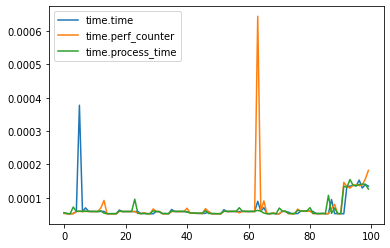

In [11]:
x = list(range(veces))
plt.plot(x,timelist,label='time.time')
plt.plot(x,perflist,label='time.perf_counter')
plt.plot(x,proclist,label='time.process_time')
plt.legend()

En la gráfica se observa que las tres curvas presentan, en general, la misma tendencia, pero con algunas distorsiones. ¿Cómo estará el promedio de los métodos de medición?

In [12]:
import statistics

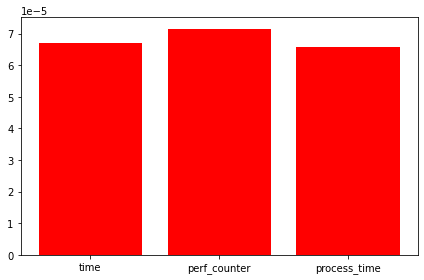

In [13]:
noms = ['time','perf_counter','process_time']
proms1 = [ 
    statistics.mean(timelist), 
    statistics.mean(perflist), 
    statistics.mean(proclist)
]
plt.bar(noms,proms1,color='r')
plt.tight_layout()

Se observa que todos los promedios están en el mismo orden de magnitud, pero que no son exactamente iguales a pesar de tratarse de la misma función, que la cantidad de pruebas es la misma y que los métodos de medición tienen una resolución similar. ¿Cuál podría ser la  causa de estas variaciones?

## Módulo timeit

El método timeit devuelve el tiempo acumulado luego de ejecutar la función indicada, la cantidad de veces en su opción `number`. Por esta razón, para obtener el tiempo promedio transcurrido se dividirá el resultado de `timeit` entre la cantidad de veces que se indique en `number`.

In [14]:
import timeit

In [15]:
setup = '''
from __main__ import func

from __main__ import a

from __main__ import b

from __main__ import c

from __main__ import d

'''

In [16]:
stmt = '''
func(a,b,c,d)
'''

In [17]:
number = 10000
timeitres = timeit.timeit(
    setup = setup,
    stmt = stmt,
    number = number
)
print('tiempo de func con timeit.timeit %f'%(timeitres/number))

tiempo de func con timeit.timeit 0.000056


Para realizar varias repeticiones `timeit` proporciona el método `repeat` el cual devuelve una lista con la cantidad de veces indicada en la opción respectiva. Igual que en el caso anterior los resultados se tienen que dividir entre la cantidad de veces porque devuelve el tiempo acumulado.

In [18]:
repeat = 100
timeitreps = timeit.repeat(
    setup = setup,
    stmt = stmt,
    number = number,
    repeat = repeat
)
repeatlist = [t/number for t in timeitreps]

Ahora se procederá a hacer una gráfica de las mediciones

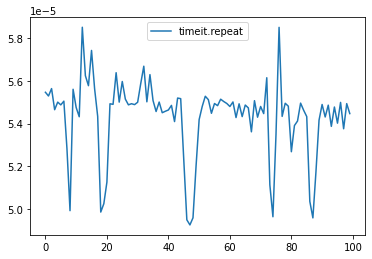

In [19]:
plt.plot(x,repeatlist,label='timeit.repeat')
plt.legend()

## Comparación de los módulos

Gráfica conjunta de las mediciones

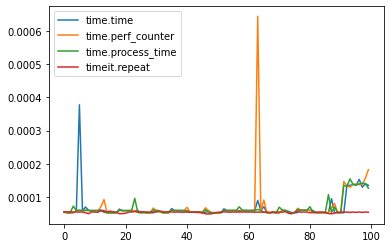

In [20]:
plt.plot(x,timelist,label='time.time')
plt.plot(x,perflist,label='time.perf_counter')
plt.plot(x,proclist,label='time.process_time')
plt.plot(x,repeatlist,label='timeit.repeat')
plt.legend()

Ahora se graficarán los tiempos promedio de todos los métodos.

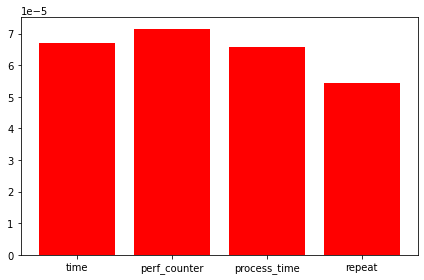

In [21]:
noms = ['time','perf_counter','process_time','repeat']
proms2 = [ 
    statistics.mean(timelist), 
    statistics.mean(perflist), 
    statistics.mean(proclist),
    statistics.mean(repeatlist)
]
plt.bar(noms,proms2,color='r')
plt.tight_layout()

Se observa que las mediciones realizadas con los métodos proporcionados por los dos módulos son irregulares, es decir, ambas mediciones presentan picos. Sumar estos picos que se ha introducido en nuestras mediciones y luego promediar implicaría que estas irregularidades están incluidas en el cómputo del promedio y esto desviaría el resultado final de lo real. ¿Cómo medir esta distorsión? ¿Cómo eliminar el ruido?

## Filtro mediana unidimensional

El filtro de mediana es un algoritmo empleado para eliminar ruido.

In [22]:
def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [23]:
ventana = 7
timelistsr = filtro_mediana(timelist,ventana)

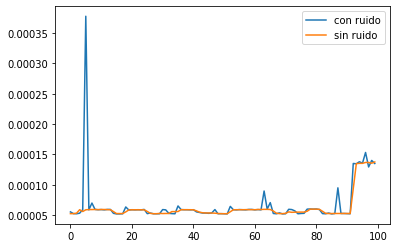

In [24]:
# gráfico de las mediciones realizadas con time.time con y sin ruido
plt.plot(x,timelist, label='con ruido')
plt.plot(x,timelistsr, label='sin ruido')
# para mostrar la leyenda
plt.legend()

In [25]:
perflistsr = filtro_mediana(perflist,ventana)

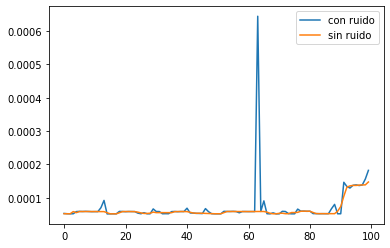

In [26]:
# gráfico de las mediciones realizadas con time.perf_counter con y sin ruido
plt.plot(x,perflist, label='con ruido')
plt.plot(x,perflistsr, label='sin ruido')
# para mostrar la leyenda
plt.legend()

In [27]:
proclistsr = filtro_mediana(proclist,ventana)

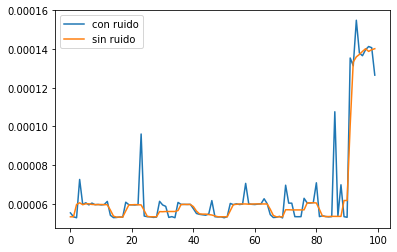

In [28]:
# gráfico de las mediciones realizadas con time.process_time con y sin ruido
plt.plot(x,proclist, label='con ruido')
plt.plot(x,proclistsr, label='sin ruido')
# para mostrar la leyenda
plt.legend()

In [29]:
repeatlistsr = filtro_mediana(repeatlist,ventana)

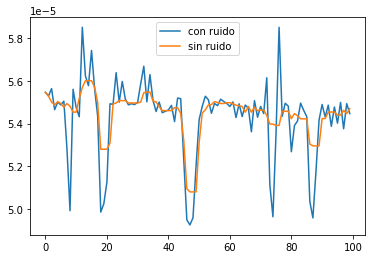

In [30]:
# gráfico de las mediciones realizadas con time.process_time con y sin ruido
plt.plot(x,repeatlist, label='con ruido')
plt.plot(x,repeatlistsr, label='sin ruido')
# para mostrar la leyenda
plt.legend()

¿Cómo se ven los tiempos sin ruido?

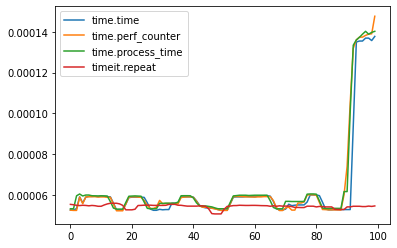

In [31]:
plt.plot(x,timelistsr,label='time.time')
plt.plot(x,perflistsr,label='time.perf_counter')
plt.plot(x,proclistsr,label='time.process_time')
plt.plot(x,repeatlistsr,label='timeit.repeat')
plt.legend()

¿Varían mucho los promedios luego de la eliminación del ruido?

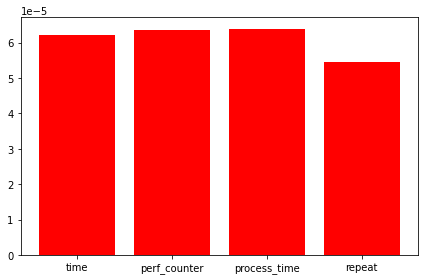

In [32]:
noms = ['time','perf_counter','process_time','repeat']
promssr = [ 
    statistics.mean(timelistsr), 
    statistics.mean(perflistsr), 
    statistics.mean(proclistsr),
    statistics.mean(repeatlistsr)
]
plt.bar(noms,promssr,color='r')
plt.tight_layout()

¿Qué impacto tuvo eliminar el ruido de las señales en el valor final de los promedios? ¿Fueron significativas las distorsiones introducidas en las mediciones? ¿Cuál es la diferencia entre el promedio con ruido y sin ruido? Se deja estas preguntas para su reflexión.

# Implementación de funciones

En esta sección de implementará una función que calcula la suma de números enteros desde el $1$ hasta el número anterior indicado en su argumento. 

$$
\begin{align}
\sum_{k=1}^{n-1}k
\end{align}
$$


Esta será implementada de múltiples formas con el propósito de mostrar como la implementación se puede traducir en tiempos de ejecución mayores o menores.

## Implementación con fórmula

Es probable que algunos usuarios, sea por cultura general, por formación, o por alguna razón cualquiera,  ya sepan que esa sumatoria tiene un resultado notable.

$$
\begin{align}
\frac{(n-1)n}{2}
\end{align}
$$

Está será la primera implementación

In [33]:
def sumar_enteros_formula(n=100_000):
    return int((n*(n-1))/2)

In [34]:
timeit.timeit(sumar_enteros_formula,number=1)

2.6859997888095677e-06

In [35]:
timeit.timeit(sumar_enteros_formula,number=10)/10

4.5020001380180476e-07

In [36]:
timeit.timeit(sumar_enteros_formula,number=100)/100

1.9192000308976275e-07

## Implementación con funciones internas

Imagine que usted desconocía que el resultado de la sumatoria era notable. Un camino alternativo, es emplear las funciones internas que proporciona el lenguaje.

In [37]:
def sumar_enteros_idiomatic(n=100_000):
    return sum(range(n))

In [38]:
timeit.timeit(sumar_enteros_idiomatic,number=1)

0.001114943000175117

In [39]:
timeit.timeit(sumar_enteros_idiomatic,number=10)/10

0.0011519827000029182

In [40]:
timeit.timeit(sumar_enteros_idiomatic,number=100)/100

0.001145526640002572

## Implementación for

Ahora suponga que usted es un usuario poco familiarizado con Python, y no sabía de estas funciones internas, pero está relativamente habituado a la sintaxis, y decide usar un bucle `for`.

In [41]:
def sumar_enteros_for(n=100_000):
    s = 0
    for i in range(n):
        s += i
    return s

In [42]:
timeit.timeit(sumar_enteros_for,number=1)

0.003450418999818794

In [43]:
timeit.timeit(sumar_enteros_for,number=10)/10

0.0034587901999657334

In [44]:
timeit.timeit(sumar_enteros_for,number=100)/100

0.003610340300001553

Un usuario aún más inexperto quizás interaría algo con la siguiente forma:

In [45]:
def sumar_enteros_for_incremento(n=100_000):
    s = 0
    c = 0
    for i in range(n):
        s += c
        c += 1
    return s

In [46]:
timeit.timeit(sumar_enteros_for_incremento,number=1)

0.006406569000318996

In [47]:
timeit.timeit(sumar_enteros_for_incremento,number=10)/10

0.0063905099000294285

In [48]:
timeit.timeit(sumar_enteros_for_incremento,number=100)/100

0.00630345029000182

Bastó con incluir un contador distinto del índice y acumularlo para que el tiempo sea mayor a la implementación con anterior. ¿Qué pasaría si se incluye una operación de comparación porque desconoce del funcionamiento del bucle `for`?

In [49]:
def sumar_enteros_for_incremento_comp(n=100_000):
    s = 0
    c = 0
    for i in range(n):
        if i < n: 
            s += c
            c += 1
    return s

In [50]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=1)

0.008187398999780271

In [51]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=10)/10

0.008175903100027426

In [52]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=100)/100

0.0076293956099971185

Al añadir la operación de comparación la función ahora es incluso más lenta, y eso que los añadidos son operaciones muy sencillas.

## Implementación while

Quizás usted no entendió el uso del bucle `for` en la documentación y el bucle `while` le resulta más parecido a otros lenguajess de programación que ya ha empleado.

In [53]:
def sumar_enteros_while(n=100_000):
    i = 0
    s = 0
    while (i < n):
        s += i
        i += 1
    return s

In [54]:
timeit.timeit(sumar_enteros_while,number=1)

0.007319155999994109

In [55]:
timeit.timeit(sumar_enteros_while,number=10)/10

0.007463831899985962

In [56]:
timeit.timeit(sumar_enteros_while,number=100)/100

0.006493551399998978

Se observa que la primera implmentación de la función que emplea el bucle `for` es ligeramente más rápida que la función implementada con bucle `while`. Esto se debe a que la implementación con bucle `for` está más optimizada a nivel de ensamblador. Se debe tener en cuenta estos detalles para implementar funciones. 

## Comparación de las funciones implementadas

Se definen funciones con lo aprendido para poder usarlo de forma modular

In [57]:
def medir_timeit(setup,stmt,number,repeat):
    timeitreps = timeit.repeat(
        setup = setup,
        stmt = stmt,
        number = number,
        repeat = repeat
    )
    return [t/number for t in timeitreps]

In [58]:
def medir_time(f,veces):
    times = []
    tic = 0
    toc = 0
    e = 0
    for i in range(veces):
        tic = time.time()
        f()
        toc = time.time()
        e = toc - tic
        times.append(e)
    return times

Mediciones con timeit

In [59]:
setup = '''
from __main__ import sumar_enteros_formula
'''
stmt='''
sumar_enteros_formula()
'''
number = 100
repeat = 100
t0 = medir_timeit(setup,stmt,number,repeat)

In [60]:
setup = '''
from __main__ import sumar_enteros_idiomatic
'''
stmt='''
sumar_enteros_idiomatic()
'''
t1 = medir_timeit(setup,stmt,number,repeat)

In [61]:
setup = '''
from __main__ import sumar_enteros_for
'''
stmt='''
sumar_enteros_for()
'''
t2 = medir_timeit(setup,stmt,number,repeat)

In [62]:
setup = '''
from __main__ import sumar_enteros_for_incremento
'''
stmt='''
sumar_enteros_for_incremento()
'''
t3 = medir_timeit(setup,stmt,number,repeat)

In [63]:
setup = '''
from __main__ import sumar_enteros_for_incremento_comp
'''
stmt='''
sumar_enteros_for_incremento_comp()
'''
t4 = medir_timeit(setup,stmt,number,repeat)

In [64]:
setup = '''
from __main__ import sumar_enteros_while
'''
stmt='''
sumar_enteros_while()
'''
t5 = medir_timeit(setup,stmt,number,repeat)

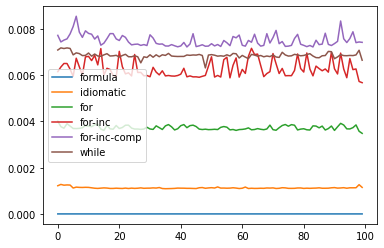

In [65]:
x = list(range(repeat))
plt.plot(x, t0, label='formula')
plt.plot(x, t1, label='idiomatic')
plt.plot(x, t2, label='for')
plt.plot(x, t3, label='for-inc')
plt.plot(x, t4, label='for-inc-comp')
plt.plot(x, t5, label='while')
# para mostrar la leyenda
plt.legend()

Luego de pasar filtro mediano a las mediciones

In [66]:
t0sr = filtro_mediana(t0, 7)

In [67]:
t1sr = filtro_mediana(t1, 7)

In [68]:
t2sr = filtro_mediana(t2, 7)

In [69]:
t3sr = filtro_mediana(t3, 7)

In [70]:
t4sr = filtro_mediana(t4, 7)

In [71]:
t5sr = filtro_mediana(t5, 7)

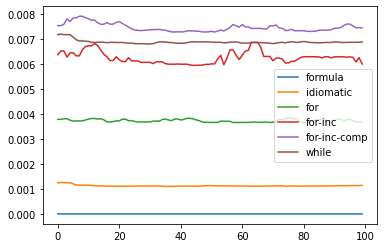

In [72]:
plt.plot(x, t0sr, label='formula')
plt.plot(x, t1sr, label='idiomatic')
plt.plot(x, t2sr, label='for')
plt.plot(x, t3sr, label='for-inc')
plt.plot(x, t4sr, label='for-inc-comp')
plt.plot(x, t5sr, label='while')
# para mostrar la leyenda
plt.legend()

Mediciones con time

In [73]:
r0 = medir_time(sumar_enteros_formula,100)

In [74]:
r1 = medir_time(sumar_enteros_idiomatic,100)

In [75]:
r2 = medir_time(sumar_enteros_for,100)

In [76]:
r3 = medir_time(sumar_enteros_for_incremento,100)

In [77]:
r4 = medir_time(sumar_enteros_for_incremento_comp,100)

In [78]:
r5 = medir_time(sumar_enteros_while,100)

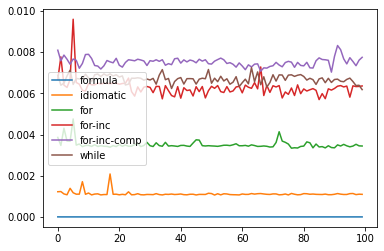

In [79]:
plt.plot(x, r0, label='formula')
plt.plot(x, r1, label='idiomatic')
plt.plot(x, r2, label='for')
plt.plot(x, r3, label='for-inc')
plt.plot(x, r4, label='for-inc-comp')
plt.plot(x, r5, label='while')
# para mostrar la leyenda
plt.legend()

Luego de pasar filtro mediano a las mediciones

In [80]:
r0sr = filtro_mediana(r0, 7)

In [81]:
r1sr = filtro_mediana(r1, 7)

In [82]:
r2sr = filtro_mediana(r2, 7)

In [83]:
r3sr = filtro_mediana(r3, 7)

In [84]:
r4sr = filtro_mediana(r4, 7)

In [85]:
r5sr = filtro_mediana(r5, 7)

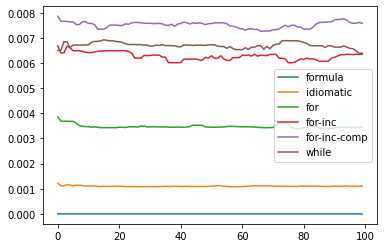

In [86]:
plt.plot(x, r0sr, label='formula')
plt.plot(x, r1sr, label='idiomatic')
plt.plot(x, r2sr, label='for')
plt.plot(x, r3sr, label='for-inc')
plt.plot(x, r4sr, label='for-inc-comp')
plt.plot(x, r5sr, label='while')
# para mostrar la leyenda
plt.legend()

Para la función idiomática ¿Cómo quedan las mediciones de `timeit.repeat` luego de eliminar el ruido?

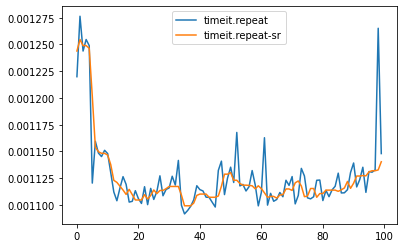

In [87]:
plt.plot(x, t1, label='timeit.repeat')
plt.plot(x, t1sr, label='timeit.repeat-sr')
# para mostrar la leyenda
plt.legend()

¿Y para `time.time`?

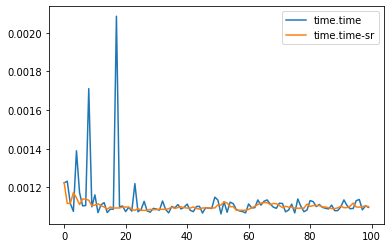

In [88]:
plt.plot(x, r1, label='time.time')
plt.plot(x, r1sr, label='time.time-sr')
# para mostrar la leyenda
plt.legend()

Para la misma función ¿Cómo varían los promedios de los dos métodos?

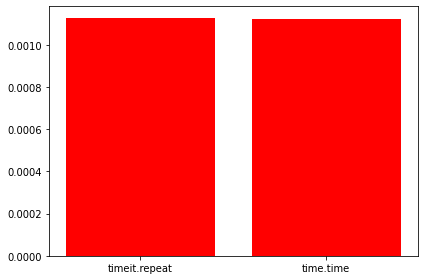

In [89]:
noms = ['timeit.repeat','time.time']
proms = [ 
    statistics.mean(t1), 
    statistics.mean(r1)
]
plt.bar(noms,proms,color='r')
plt.tight_layout()

¿Después de la eliminación de ruido?

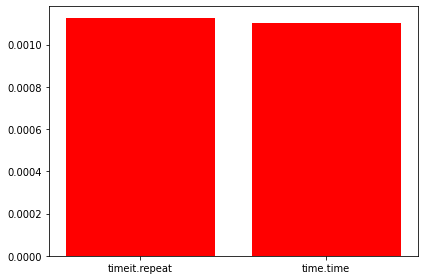

In [90]:
noms = ['timeit.repeat','time.time']
proms = [ 
    statistics.mean(t1sr), 
    statistics.mean(r1sr)
]
plt.bar(noms,proms,color='r')
plt.tight_layout()

¿Será importante eliminar el ruido? ¿Cómo variaría el tiempo si cambiaramos el argumento a pasos de 100mil? ¿La tendencia sería la misma en todas las implementaciones? Se dejan estos dudas para el lector.

## Característica del equipo

Los resultados fueron obtenidos al ejecutar el cuaderno en una máquina virtual con cuatro núcleos y 4GB de RAM. Por esta razón, usted podría obtener resultados muy diferentes al ejecutarlo en su equipo.